<b>Diabetes Data Set</b> (reference to UCI Machine Learning Repository <a href="https://archive.ics.uci.edu/ml/datasets/diabetes">description</a>)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 8

import numpy as np
np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

import pandas as pd
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 200)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision', 6)

import seaborn as sns
sns.set()

from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

from lib.utils import *
from lib.outlierdetection import *

%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython
gpu_stat()

tb 2018-09-13 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.2
torch 0.4.0a0+9692519
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit

GPU Name: TITAN Xp
GPU Memory: 12.0GB
CUDA Version: (9, 1, 0)
GPU Free/Total Memory: 68%


In [2]:
# Hyperparameters
HP = HYPERPARAMETERS({
    "SEED"                : 0
})

In [3]:
# Seed random generators for repro 
np.random.seed(HP.SEED)  

In [4]:
# https://archive.ics.uci.edu/ml/datasets/diabetes
dataframe = pd.read_csv("data/diabetic_data.csv")
dataframe.drop('encounter_id', axis=1, inplace=True)
dataframe.drop('patient_nbr', axis=1, inplace=True)
dataframe.drop('payer_code', axis=1, inplace=True)
dataframe.drop('weight', axis=1, inplace=True)

In [5]:
dataframe['readmitted'] = dataframe['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

cols = list(dataframe)
cols.insert(0, cols.pop(cols.index('readmitted')))
dataframe = dataframe.loc[:, cols]

feature_names = dataframe.columns[1:]
target_names = ['no', 'readmitted']

# Transform data form categorial to numeric
cat_variables = [i for i in dataframe.columns[1:] if dataframe[i].dtype == 'object']
encods = [LabelEncoder() for col in cat_variables]
for i, col in enumerate(cat_variables):
    dataframe[col] = encods[i].fit_transform(dataframe[col].astype(str))
    
data = dataframe

In [6]:
X = np.float32(data.values[:,1:])
y = np.int64(data.values[:,0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=HP.SEED)

dataset_statistics(X_train, y_train, X_test, y_test, target_names)


Dataset statistics:
number of features:       45
number of classes:        2
data type:                float32
number of train samples:  81412 (pos=9116, neg=72296, size=14MB)
number of test samples:   20354 (pos=2241, neg=18113, size=3MB)
labels                    ['no', 'readmitted']


In [7]:
from sklearn.ensemble import GradientBoostingClassifier
params = {
    'classifier__learning_rate': 0.05,
    'classifier__max_depth': 8,
    'classifier__max_features': 0.3,
    'classifier__min_samples_leaf': 100,
    'classifier__n_estimators': 32}

pipeline = Pipeline(steps=[
              ('scaler',     StandardScaler(copy=True, with_mean=True, with_std=True)),
              ('sampler',    SMOTE(random_state=HP.SEED)),
              ('classifier', GradientBoostingClassifier())
])

pipeline.set_params(**params)

scoring = 'f1'

for pip_name in pipeline.named_steps:
    display(pipeline.named_steps[pip_name])

StandardScaler(copy=True, with_mean=True, with_std=True)

SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=0, ratio='auto', svm_estimator=None)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=32,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

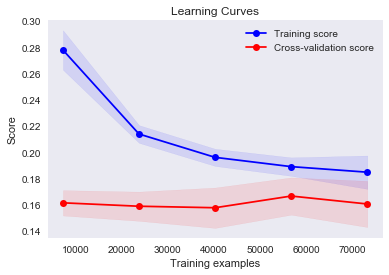

In [8]:
cv = KFold(n_splits=10, shuffle=True, random_state=None).split(X_train)

_ = plot_learning_curve(pipeline, 'Learning Curves', X_train, y_train, 
                    cv=cv, scoring=scoring, shuffle=False, random_state=HP.SEED, n_jobs=-1)

In [9]:
# from sklearn.model_selection import validation_curve
# param_name = 'classifier__max_depth'
# param_range = [ 1, 10, 11, 12, 13, 20]
# train_scores, test_scores = validation_curve(
#                  estimator=pipeline,
#                  X=X_train,
#                  y=y_train,
#                  param_name=param_name,
#                  scoring='accuracy',
#                  param_range=param_range,
#                  cv=10,
#                  n_jobs=-1)

# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# plt.plot(param_range, train_mean,
#           color='blue', marker='o',
#           markersize=5,
#           label='training accuracy')
# plt.fill_between(param_range, train_mean + train_std,
#                   train_mean - train_std, alpha=0.15,
#                   color='blue')
# plt.plot(param_range, test_mean,
#           color='green', linestyle='--',
#           marker='s', markersize=5,
#           label='validation accuracy')
# plt.fill_between(param_range,
#                   test_mean + test_std,
#                   test_mean - test_std,
#                   alpha=0.15, color='green')
# plt.grid()
# #plt.xscale('log')
# plt.legend(loc='lower right')
# plt.xlabel('Parameter C')
# plt.ylabel('Accuracy')
# plt.ylim([0.8, 1.0])
# plt.show()

Trainings score: 0.18347841437835818 0.007517059841810474
Validation score: 0.16095800406019756 0.014476137877634684


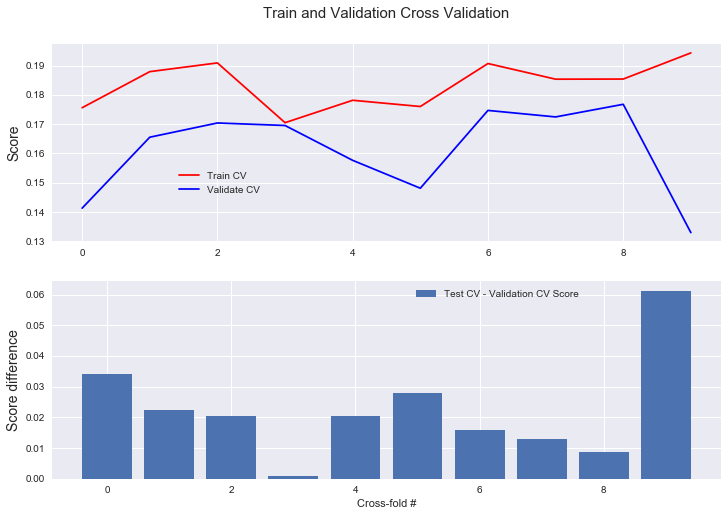

In [10]:
# Cross-validate to train best model 

cv = KFold(n_splits=10, shuffle=True, random_state=HP.SEED).split(X_train)
scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, 
                        return_train_score=True, verbose=0, n_jobs=1)

print("Trainings score:", np.mean(scores['train_score']), np.std(scores['train_score']))
print("Validation score:", np.mean(scores['test_score']), np.std(scores['test_score']))
plot_cross_validation_scores(scores, figsize=(12, 8))

In [11]:
# http://www.ritchieng.com/machine-learning-evaluate-classification-model/
# https://github.com/justmarkham/DAT8/blob/master/other/model_evaluation_comparison.md\
# Accuracy of a model that simply counts, i.e. looks at the prior distribution

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
try:
    y_prob = pipeline.predict_proba(X_test)
except:
    pass

print('Confusion Matrix\n', metrics.confusion_matrix(y_test, y_pred))  # Confusion Matrix
print('Accuracy ', metrics.accuracy_score(y_test, y_pred))            # Accuracy (TP + TN) / float(TP + TN + FP + FN)
print('Recall   ', metrics.recall_score(y_test, y_pred))                # Recall (Sensitivity)   TP / float(FN + TP)
print('Precision', metrics.precision_score(y_test, y_pred))     
print('F1       ', metrics.f1_score(y_test, y_pred))     
print('ROC AUC  ', metrics.roc_auc_score(y_test, y_pred))     

Confusion Matrix
 [[17541   572]
 [ 2010   231]]
Accuracy  0.8731453276997151
Recall    0.10307898259705489
Precision 0.2876712328767123
F1        0.15177398160315375
ROC AUC   0.535749727040812


In [12]:
#  Cross-validate score on test set
cv = KFold(n_splits=10, shuffle=True, random_state=HP.SEED).split(X_test)
scores = cross_val_score(pipeline, X_test, y_test, cv=cv,  scoring="accuracy",  
                         verbose=0, n_jobs=1)

print("Test accuracy score:", np.mean(scores), np.std(scores))

Test accuracy score: 0.8694123709349644 0.008397047133073826


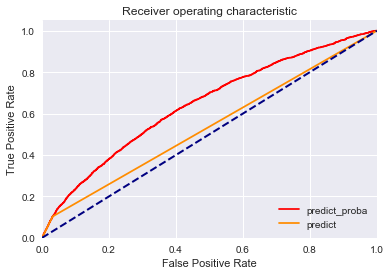

In [13]:
try:
    plot_roc_curve(y_test, y_pred, y_prob)
except:
    pass

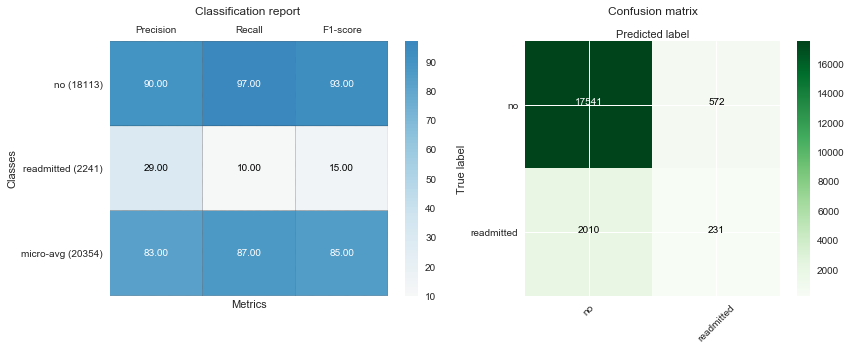

In [14]:
plot_classifier_summary(y_test, y_pred, target_names)

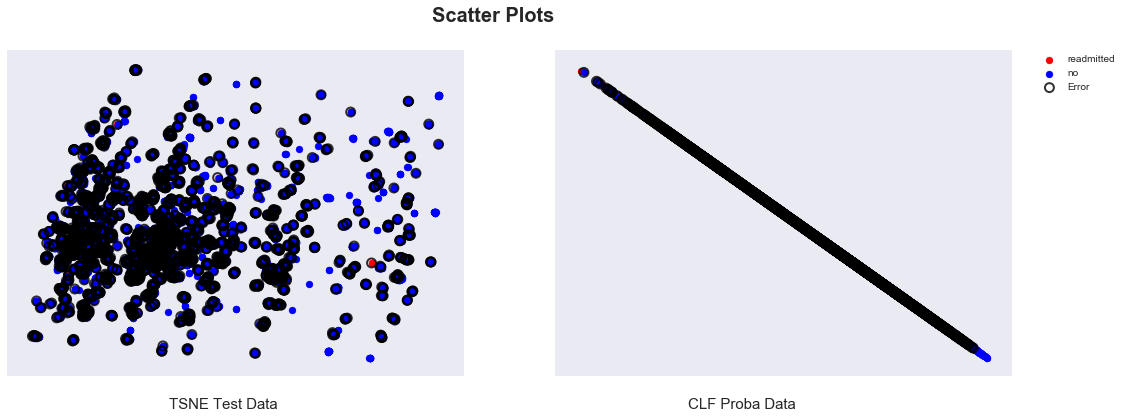

In [15]:
try:
    plot_scatter_plots(X_test, y_pred, y_prob, y_test, target_names, figsize=(18,6))
except:
    pass

In [16]:
# Check classification of full data set
classifier_summary_report(X, y, pipeline.predict(X), target_names)

Note: weighted average f1-score 
              precision    recall  f1-score   support

         no       0.90      0.97      0.93     90409
 readmitted       0.31      0.12      0.17     11357

avg / total       0.83      0.87      0.85    101766



'Data points=101766'

'Features=45'

'Class dist.=0.111599'

'F1 valid=0.168384'

'ACC=0.873140'

'ROC_AUC=0.541725'

'LOG_LOSS=4.381600'

'Misclassified=12910'

'Data points=[11, 12, 16, 29, 50, 68, 70, 77, 116, 136, 160, 162, 167, 175, 197, 220, 222, 223, 232, 235]'